# Reducing hospital readmissions

## 📖 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

## Executive Summary
* Circulatory is the most common primary diagnosis above age 50s but age of 40s are more diagnosis as other reason.
* The second and the third diagnosis are other and respiratory.
* As some doctors' belief in relationship between readmission and diabetes, there are clear relation between readmission and diabetes
* Number of lab procedure, number of medication, times in hospital, number of procedure, outpatient and inpatient features are important feature to predict whether or not patients' readmissions.
* Patients who has higher number of inpatient are higher chance to readmission but  lower number of inpatient is less likely to readmitted to the hospital.
* The number of emergency and outpatient numbers are the same as inpatient feature explanation. Patients who often carries in emergency and visit the hospital as outpatient are more likely to be readmitted compared to those are not. 
* On the other, number of medications feature can interpret opposite perspective. Those who often prescribe medicine are less likely to be readmitted than those who are not. 

In [24]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import  LGBMClassifier
import lightgbm
plt.style.use('ggplot')

In [26]:
df = pd.read_csv('data/hospital_readmissions.csv')
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [27]:
df.describe()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


In [28]:
df.isnull().sum()

age                  0
time_in_hospital     0
n_lab_procedures     0
n_procedures         0
n_medications        0
n_outpatient         0
n_inpatient          0
n_emergency          0
medical_specialty    0
diag_1               0
diag_2               0
diag_3               0
glucose_test         0
A1Ctest              0
change               0
diabetes_med         0
readmitted           0
dtype: int64

## EDA
### The most common primary diagnosis by age group

In [29]:
prim_diag_age = df.groupby(['diag_1', 'age'])['diag_1'].count().unstack()
prim_diag_age.drop('Missing', inplace=True)
prim_diag_age

age,[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
diag_1,,,,,,
Circulatory,504.0,1256.0,1962.0,2392.0,1482.0,228.0
Diabetes,369.0,393.0,385.0,385.0,181.0,34.0
Digestive,271.0,442.0,554.0,585.0,402.0,75.0
Injury,162.0,273.0,400.0,444.0,321.0,66.0
Musculoskeletal,100.0,230.0,373.0,373.0,168.0,8.0
Other,750.0,1164.0,1402.0,1693.0,1269.0,220.0
Respiratory,376.0,694.0,836.0,964.0,691.0,119.0


In [30]:
def plot_diagnosis(i, ax):
    ax = sns.barplot(y=prim_diag_age.iloc[i], x=prim_diag_age.columns, color='darkblue')
    for p in ax.patches:
        ax.annotate(int(p.get_height()),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points') 
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(str(prim_diag_age.iloc[i].name), fontsize = 12, x=0.5, y=1.1)

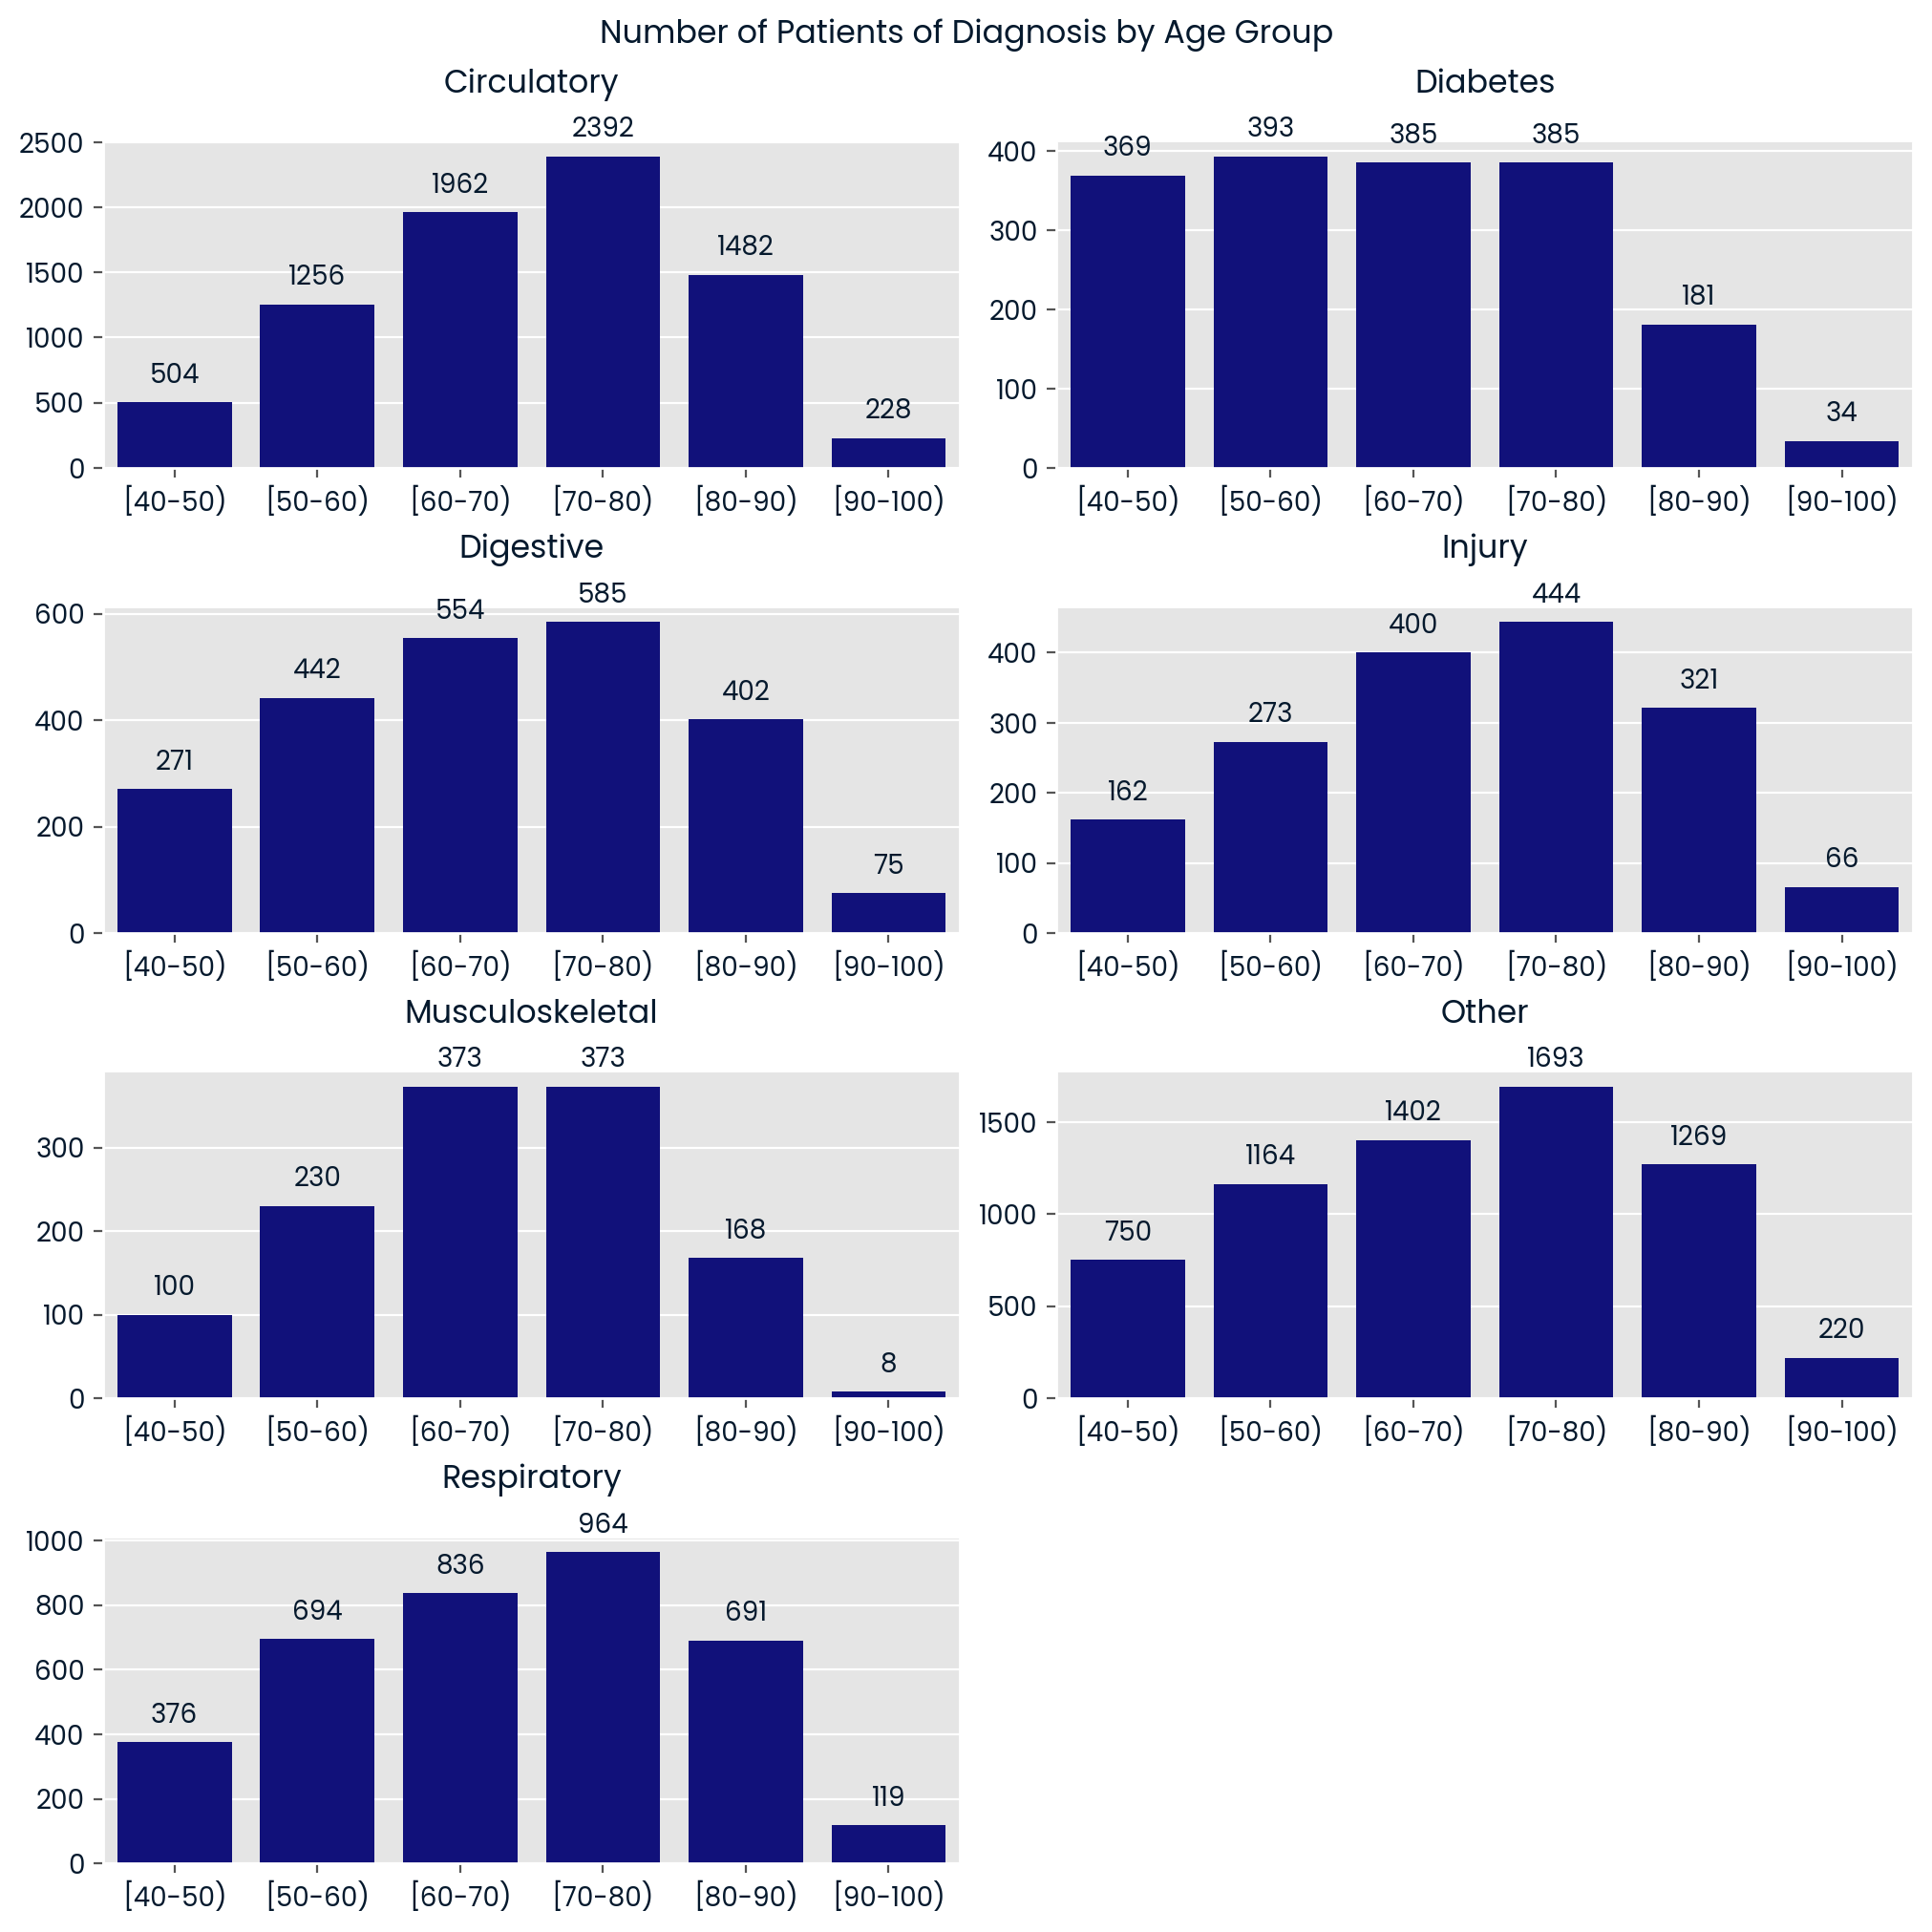

In [31]:
fig = plt.figure(layout="constrained", figsize=(10, 10))

ax1 = plt.subplot2grid((4, 2), (0, 0))
plot_diagnosis(0, ax1)
ax2= plt.subplot2grid((4, 2), (0, 1))
plot_diagnosis(1, ax2)
ax3 = plt.subplot2grid((4, 2), (1, 0))
plot_diagnosis(2, ax3)
ax4 = plt.subplot2grid((4, 2), (1, 1))
plot_diagnosis(3, ax4)
ax5 = plt.subplot2grid((4, 2), (2, 0))
plot_diagnosis(4, ax5)
ax6 = plt.subplot2grid((4, 2), (2, 1))
plot_diagnosis(5, ax6)
ax7 = plt.subplot2grid((4, 2), (3, 0), rowspan=2)
plot_diagnosis(6, ax7)

fig.suptitle('Number of Patients of Diagnosis by Age Group')
plt.show()

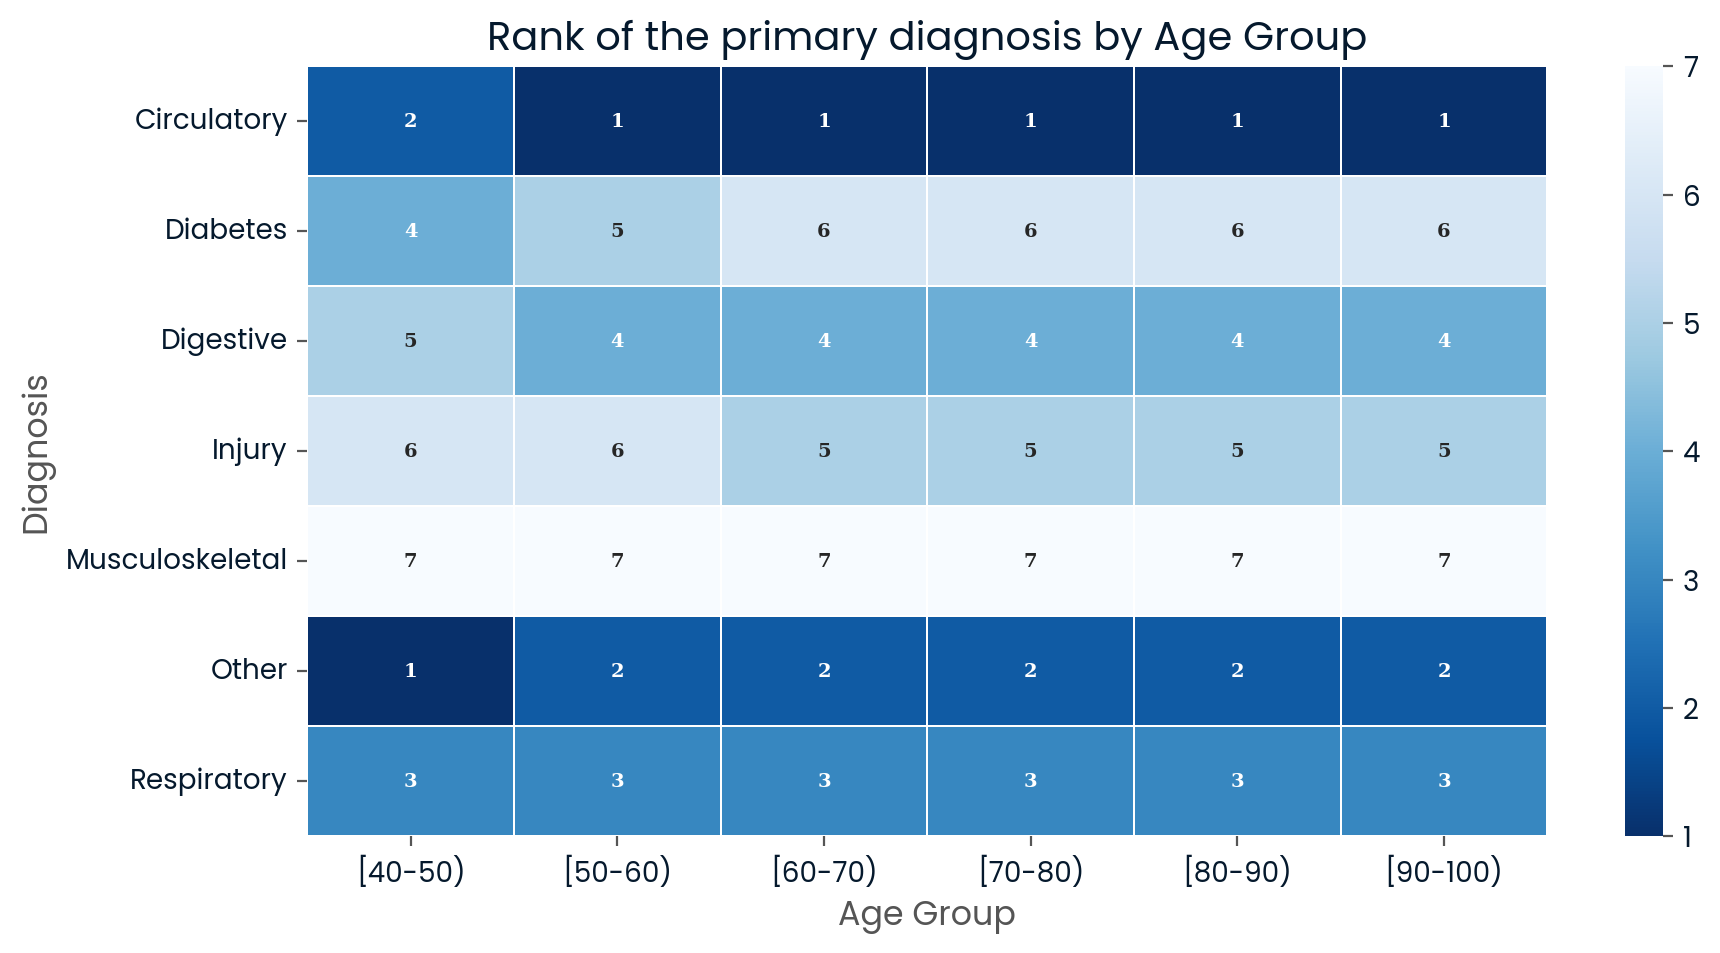

In [32]:
prim_diag_age_rank = prim_diag_age.rank(method='max', ascending=False, axis=0)
plt.figure(figsize=(10,5))
sns.heatmap(prim_diag_age_rank, cmap='Blues_r', # blue colors
            annot=True, # annotate 
            fmt=".0f", # annotation text type d: digit, f:float
            annot_kws={ # annotation detail change
                'fontsize': 7, # change font size
                'fontweight': 'bold',# bold type 
                'fontfamily': 'serif'
            }, linewidths=0.02) # make some space between lines 
plt.xlabel('Age Group')
plt.ylabel('Diagnosis')
plt.title('Rank of the primary diagnosis by Age Group')
plt.show()

* **Circulatory is the most common primary diagnosis all age group except for 40s** whose the most common diagnosis is other.
* Followed by Circulatory diagnosis,**Other takes the second place** of the most common diagnosis across all age agroups except for the 40s whose the second common diagnosis is circulatory
* **Respiratory ranks at the third** commom diagnosis across all age groups.
* **Digestive is the fourth common diagnosis above 50s age groups** and it ranks the fifth for the younger groups in this diagnosis.
* **Injury is more common  above 60s by taking the fifth common diagnosis** but for the younger groups it takes the second least common diagnosis.
* **The least common diagnosis is Musculoskeletal across all age groups.**
* Above 60s age groups shares similar ranks of the common diagnosis and the younger groups shows different frequencies of diagnosis.

### The effect of a diabetes diagnosis on readmission rates. 

In [33]:
diab_readmin = pd.crosstab(index =df.diabetes_med, columns=df.readmitted)
diab_readmin

readmitted,no,yes
diabetes_med,,
no,3385,2387
yes,9861,9367


In [34]:
chi2 = chi2_contingency(diab_readmin)
chi2[1]

1.0096710996814763e-22

* H0 means those variables are not correlated with each other if the p-value of chi2 test is higher than 0.05, it mean we can accept the null hypothesis. 
* However, the P-value from diabetes and readmission rate is lower than 0.05, Which means we can reject the hypothesis 
* Therefore, diabetes and readmission rate are correlated with each other.

###  Groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission

In [35]:
categorical_features = [i for i in df.columns if df[i].dtypes == 'object']
catset_preprocessed = pd.get_dummies(df[categorical_features], drop_first=True)

numeric_features = [i for i in df.columns if df[i].dtypes != 'object']
numset_preprocessed = df[numeric_features]
data_scaled = pd.concat([numset_preprocessed, catset_preprocessed ], axis=1)
data_scaled

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,medical_specialty_Surgery,diag_1_Diabetes,diag_1_Digestive,diag_1_Injury,diag_1_Missing,diag_1_Musculoskeletal,diag_1_Other,diag_1_Respiratory,diag_2_Diabetes,diag_2_Digestive,diag_2_Injury,diag_2_Missing,diag_2_Musculoskeletal,diag_2_Other,diag_2_Respiratory,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Missing,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal,change_yes,diabetes_med_yes,readmitted_yes
0,8,72,1,18,2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0
1,3,34,2,13,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0
2,5,45,0,18,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1
3,2,36,0,12,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,1,1
4,1,42,0,7,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14,77,1,30,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
24996,2,66,0,24,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1
24997,5,12,0,6,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1
24998,2,61,3,15,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0


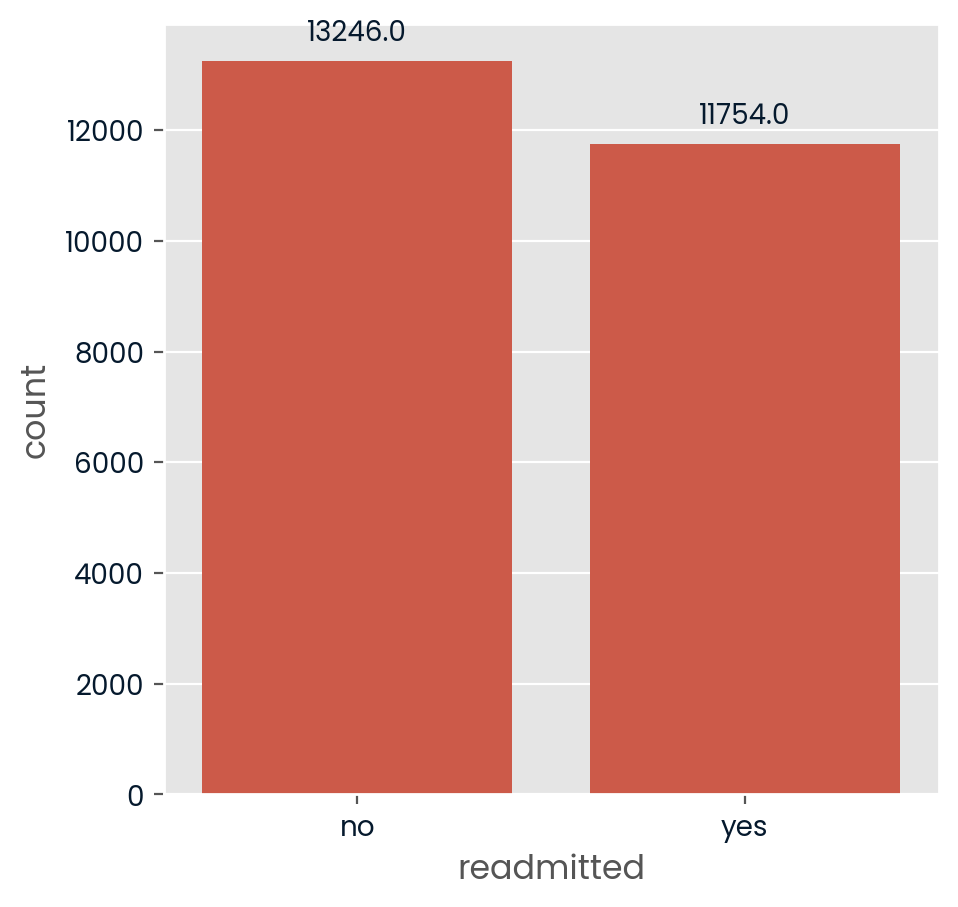

In [36]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=df["readmitted"])
for p in ax.patches:
    ax.annotate(p.get_height(),
                   (p.get_x() + p.get_width() / 2., p.get_height()),# coordinates text (x, y)
                   ha = 'center', va = 'center',# alignment of the text
                   xytext = (0, 10),# distance of text from top of the patch
                   textcoords = 'offset points')

* The number of readmitted data is not equally divided but it is given enough not to consider stratified distribution. 

In [37]:
rnd = 3
y = data_scaled.readmitted_yes
X = data_scaled.drop("readmitted_yes", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd)
print(X_train.shape, X_test.shape)

(17500, 45) (7500, 45)


In [38]:
# change some columns names to prevent Json error
X_train.columns = X_train.columns.str.replace('[','_')
X_train.columns = X_train.columns.str.replace('[','_')
X_test.columns = X_test.columns.str.replace(')','_')
X_test.columns = X_test.columns.str.replace(')','_')

In [39]:
lgb = LGBMClassifier()
evlas =[(X_test, y_test)]
lgb.fit(X_train, y_train)
print("train score",lgb.score(X_train, y_train))
pred = lgb.predict(X_test)
pred_proba = lgb.predict_proba(X_test)[:,1]
print("prediction score",accuracy_score(y_test, pred))

train score 0.6943428571428572
prediction score 0.6221333333333333


In [40]:
from sklearn.model_selection import RandomizedSearchCV
dists = {'learning_rate': [0.05], 'num_leaves':[70], 'max_depth':[3, 5, 10, 15]}
rndsearch = RandomizedSearchCV(lgb, param_distributions=dists, cv=5, verbose = 1, n_iter = 3000, random_state=0)
rndsearch.fit(X_train, y_train)

best_grid = rndsearch.best_estimator_
pred = best_grid.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(best_grid)
print(accuracy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
LGBMClassifier(learning_rate=0.05, max_depth=5, num_leaves=70)
0.6233333333333333


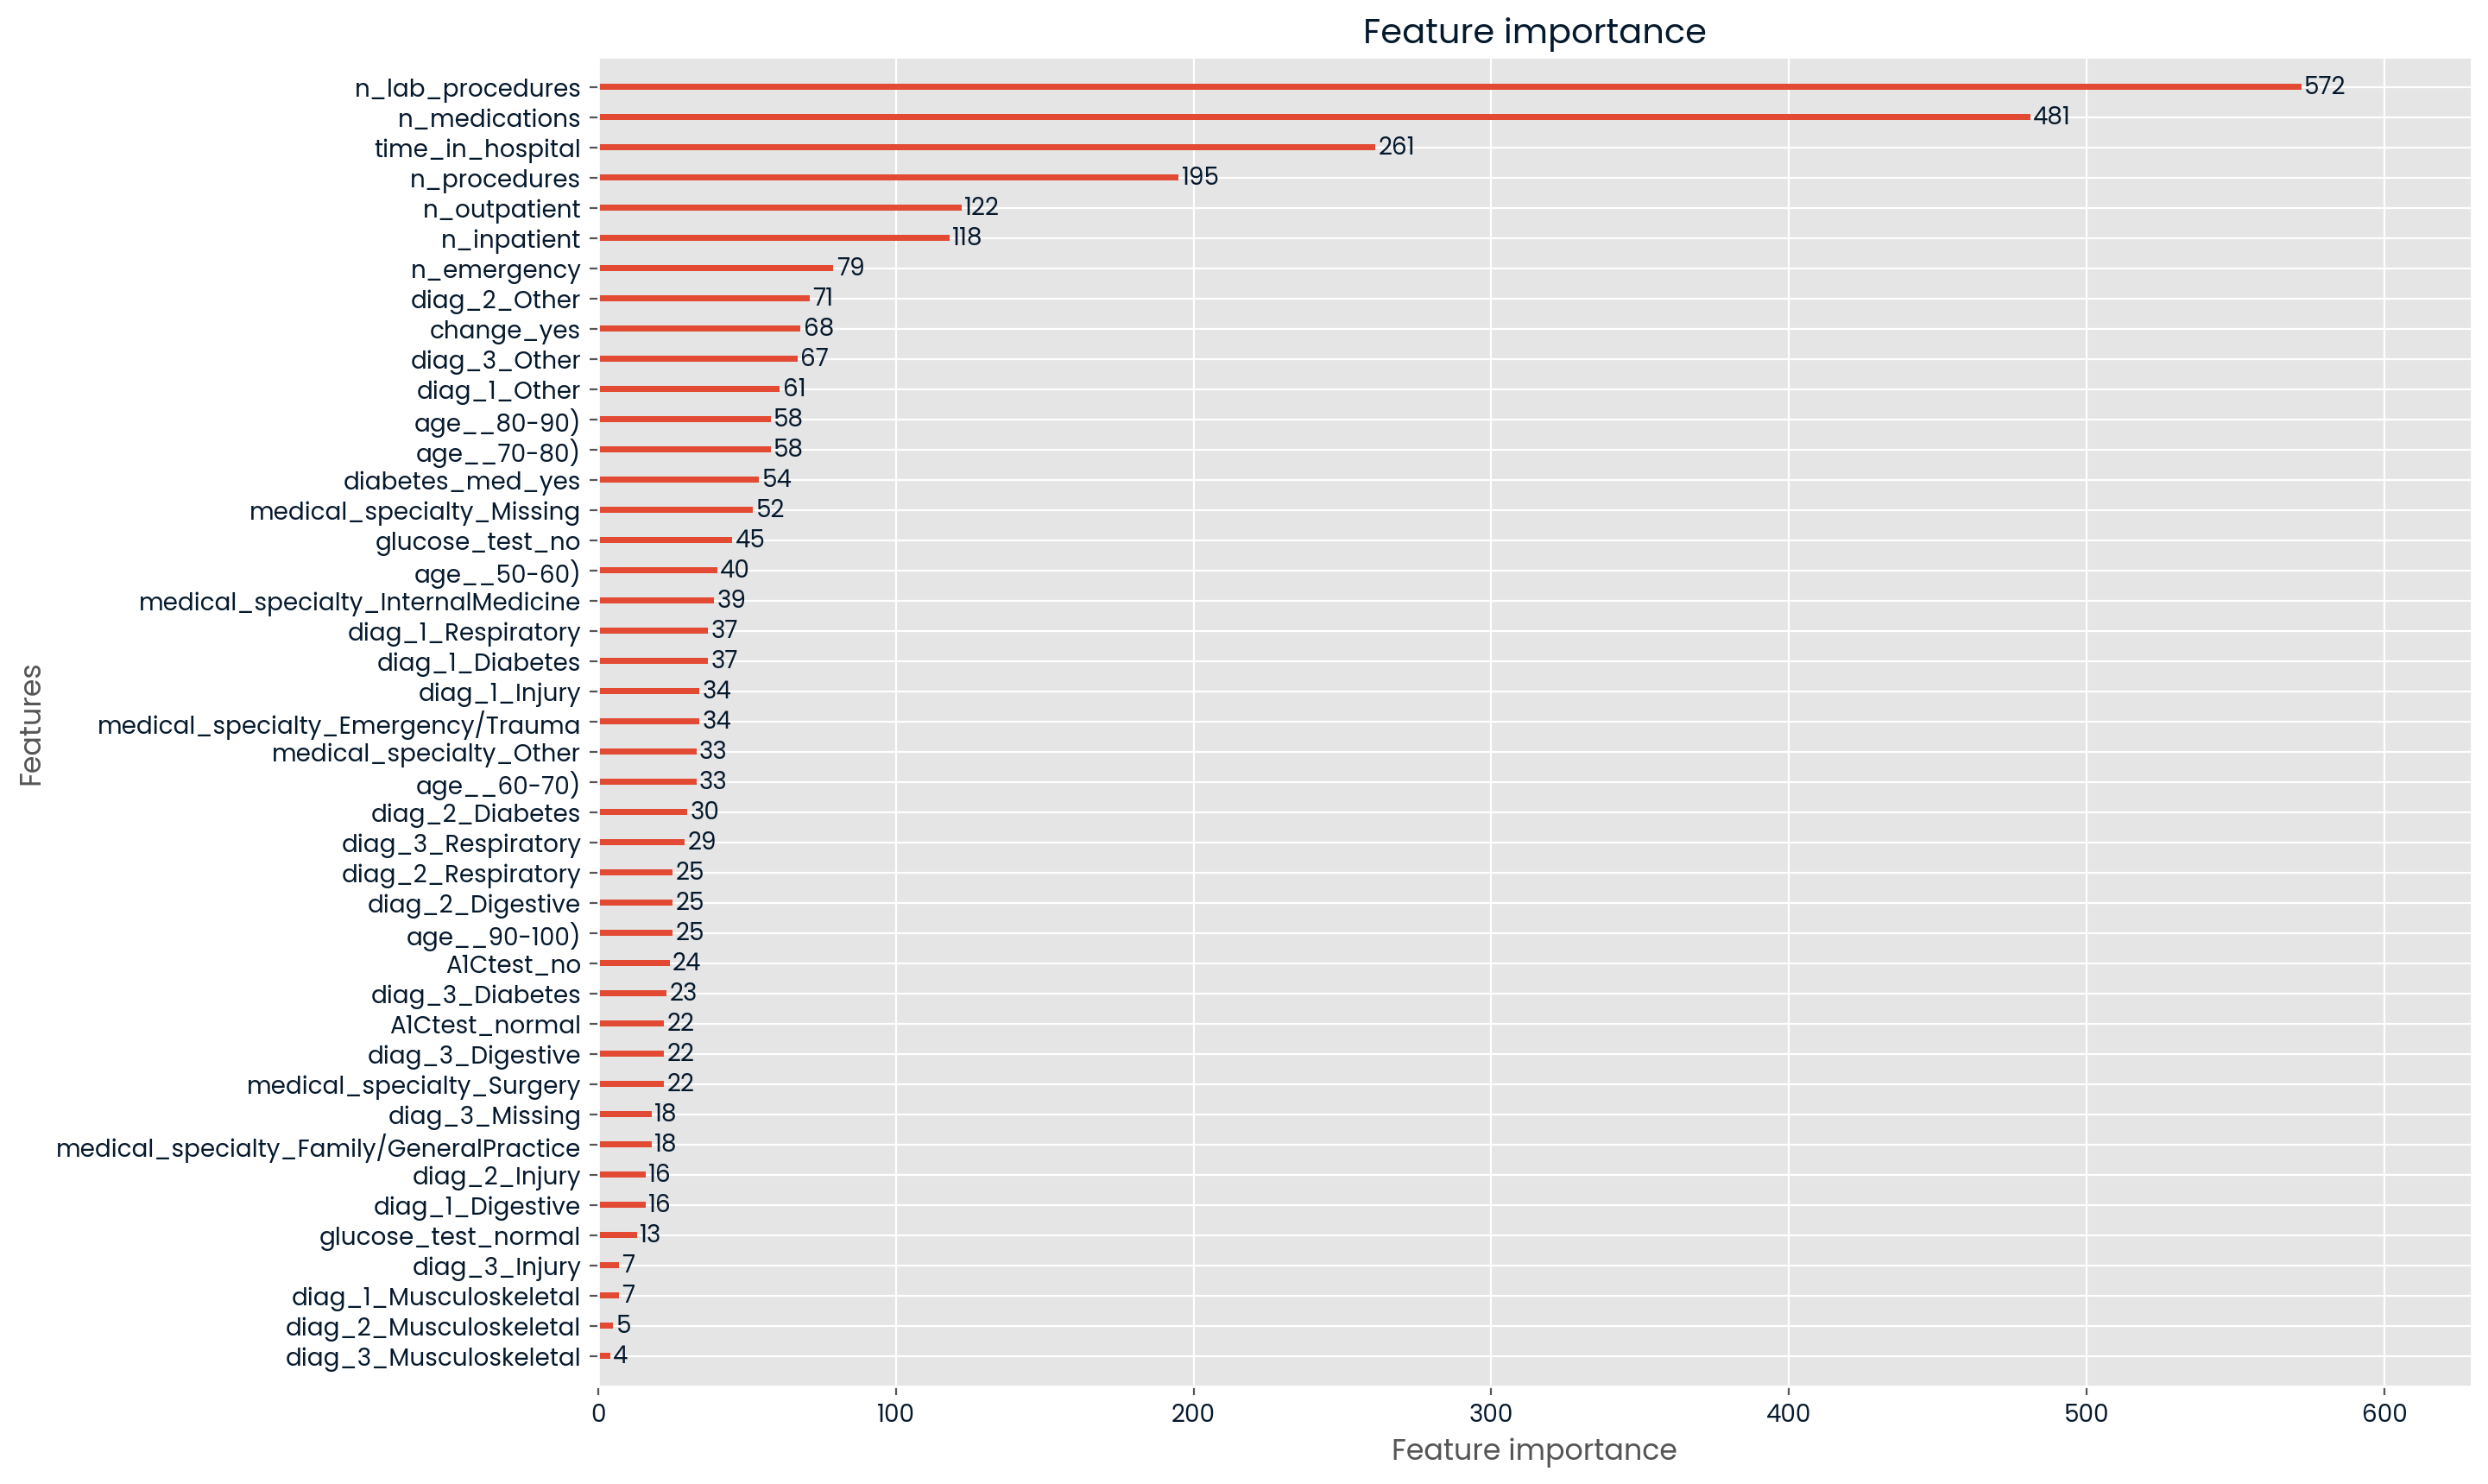

In [43]:
plt.rcParams["figure.figsize"] = (14, 10)
lightgbm.plot_importance(lgb)
plt.show()

* From the result, number of lab prececures, number of medication, times in hospital, number of procedure, outpatien and inpatient are important features when we expect hostpital readmissions. 
* Patients' age and their name of a disease do not seem to important factor for patients readmission. 

100%|===================| 7477/7500 [00:18<00:00]        

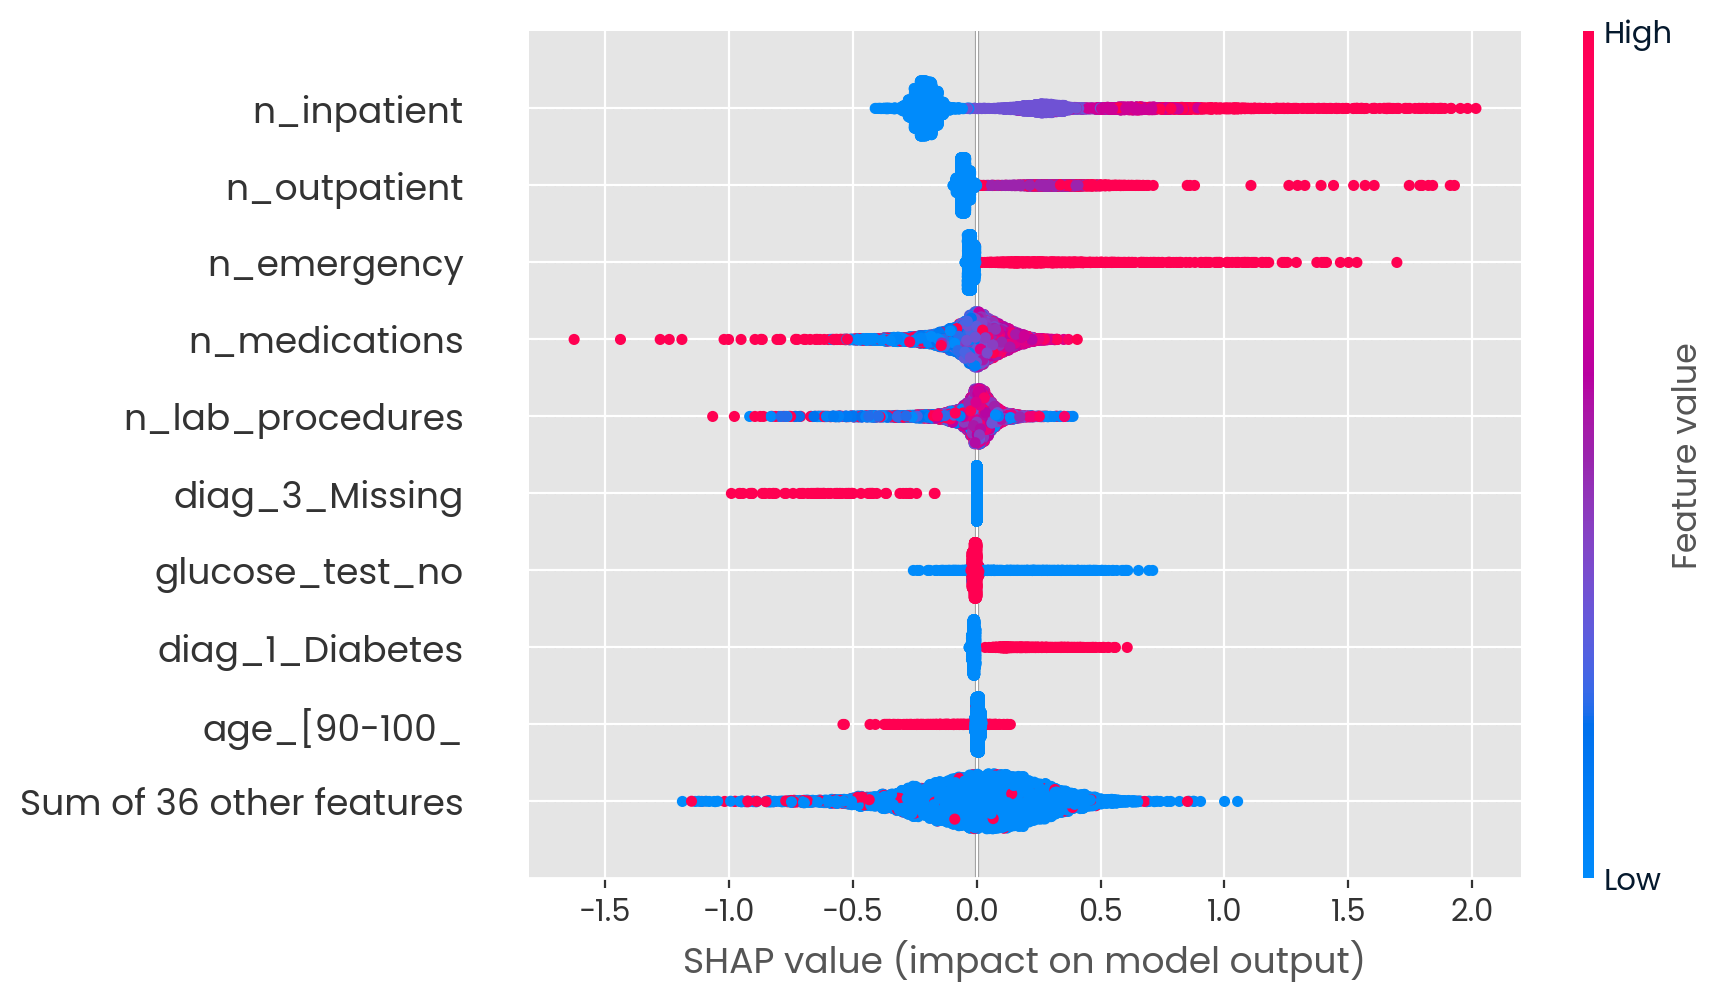

In [42]:
import shap
# compute SHAP values
explainer = shap.Explainer(lgb, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))

* Patients who has higher number of inpatient are higher chance to readmission but  lower number of inpatient is less likely to readmitted to the hospital.
* The number of emergency and outpatient numbers are the same as inpatient feature explanation. Patients who often carries in emergency and visit the hospital as outpatient are more likely to be readmitted compared to those are not. 
* On the other, number of medications feature can interpret opposite perspective. Those who often prescribe medicine are less likely to be readmitted than those who are not. 

## Summary


## Limitation
* The accuracy score of model is not high enough. Hence it requires search hyperparameters to enhance its prediction score. 
* In Here, the only one model is used for prediction of readmission of patients. It will be more powerful if it uses other models such as logistic regression, KNN which are different methodology to predict problems. 